# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных
Данные находятся в файле /datasets/autos.csv

**Признаки**

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

**Целевой признак**

Price — цена (евро)

Основные шаги:

Загрузите данные, путь к файлу: /datasets/autos.csv

Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. 

Если среди признаков имеются неинформативные, удалите их.

Подготовьте выборки для обучения моделей.

Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

Проанализируйте время обучения, время предсказания и качество моделей.

Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:

Для оценки качества моделей применяйте метрику RMSE.

Значение метрики RMSE должно быть меньше 2500.

Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.

Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.

Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.

Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del: 

del features_train

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder,StandardScaler)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.feature_extraction import DictVectorizer

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
print(f"\n Информация о выборке \n")
display(data.head())
print("\n")
display(data.info())
print("\n")
display(data.describe())
print("\n")
print(data.shape)
print(f"\n Явных дубликатов", data.duplicated().sum())


 Информация о выборке 



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), objec

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000




(354369, 16)

 Явных дубликатов 4


In [4]:
data = data.drop_duplicates()

In [5]:
print(data.isna().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [6]:
columns_to_replace = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Repaired']
for i in columns_to_replace:
    data[i] = data[i].fillna('other')
    
# print(data['Gearbox'].unique())

Оценим с помощью функции describe статистические данные столбцов датасета, в результате ее применения можно сделать вывод о распределении значений числовых столбцов , например - стандартное отклонение, квартили, медианное значнеие, максимальное и минимальное.
Для категориальных признаков видно число уникальных значений, их количество, наиболее часто встречающийся признак, частота его появления

In [7]:
data.describe(include = "all")

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354365,354365.000000,354365,354365.000000,354365,354365.000000,354365,354365.000000,354365.000000,354365,354365,354365,354365,354365.0,354365.000000,354365
unique,271174,NaN,8,NaN,3,NaN,250,NaN,NaN,7,40,3,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,other,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268249,NaN,44125,NaN,NaN,216349,77012,247158,13718,NaN,NaN,17
mean,NaN,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,5.714650,NaN,NaN,NaN,NaN,0.0,50508.503800,NaN
std,NaN,4514.176349,NaN,90.228466,NaN,189.851330,NaN,37905.083858,3.726432,NaN,NaN,NaN,NaN,0.0,25783.100078,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Сперва я хотела убрать имеющиеся в ключевых столбцах выбросы методом интерввартильного размаха, но что-то пошло не так и я решила подкорректировать выбросы вручную.
Я вижу, что у меня минимальными значениями в целевом столбце Price и признаке Power являются нулевые значения, 

Оценю распределение целевого столбца визуально, вижу, что есть нулевые выбросы,а медианное значение близко к нижнему квартилю, я думаю, что так как 75% занчений выше  1050 у.е, начну отсчет с него.

<AxesSubplot:>

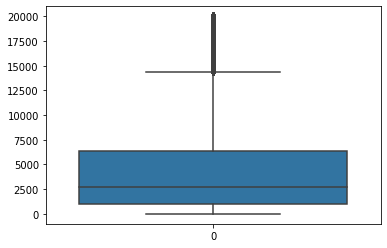

In [8]:
sns.boxplot(data=data['Price'])

Ограничила нижний диапазон цены значениями первого квартиля, убрала верхнее ограничение/

In [9]:
data = data.query('Price >= 1050')

Визуально оценю данные о годе регистрации автомобиля. Максимальное значение 9999.00 - явно выброс,также выбросы и даты выше 2016 года, об этом говрят данны столбца DateCrawled

<AxesSubplot:xlabel='RegistrationYear'>

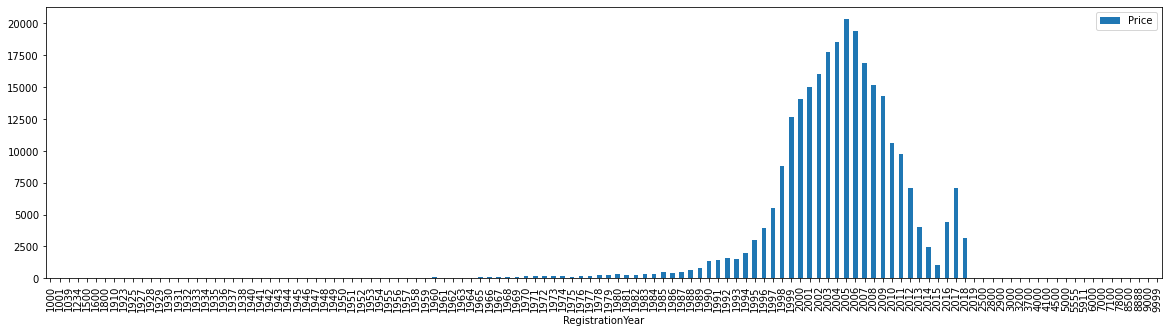

In [11]:
data.pivot_table(index='RegistrationYear', values='Price', aggfunc='count').plot.bar(figsize = (20,5))

Визуально распределение похоже на нормальное, уберу явные выбросы.

In [12]:
data = data.query('1999 <= RegistrationYear <= 2016')

Визуально оценю данные о годе регистрации автомобиля. Максимальное значение 9999.00 - явно выброс,также выбросы и даты выше 2016 года, об этом говрят данны столбца DateCrawled

Ограничу данные мощности, авто с мощностью более 1500 существенно выше медианной цены, плюс автомобили с такой мощностью явно стоят больше 20 000 уе, нижнее значение ограничу первым квартилем

In [13]:
data = data.query('69 <= Power <= 1500')


 Тепловая карта корелляции:


<AxesSubplot:>

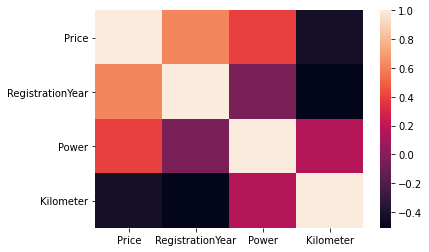

In [15]:
print(f"\n Тепловая карта корелляции:")
sns.heatmap(data[['Price', 'RegistrationYear', 'Power', 'Kilometer']].corr())

Удалю неинформативные признаки:

In [16]:
data = data.drop(['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen', 'RegistrationMonth'],axis = 1)

In [17]:
print(data.isna().sum())

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64


Пропусков нет

## Обучение моделей

Подготовьте выборки для обучения моделей.

Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

Проанализируйте время обучения, время предсказания и качество моделей.

Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:

Для оценки качества моделей применяйте метрику RMSE.

Значение метрики RMSE должно быть меньше 2500.

In [18]:
target = data['Price']
features = data.drop('Price', axis=1)

In [19]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [20]:
features_train_1 = features_train.copy()
features_test_1 = features_test.copy()

#Прямое кодирование
encoder = OrdinalEncoder()
#Код ревьюера
# encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
cat_features = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
features_train_oe = features_train[cat_features]
features_train_oe = pd.DataFrame(encoder.fit_transform(features_train_oe),
                             columns=features_train_oe.columns, index=features_train_oe.index)
for i in cat_features:
    features_train[i] = features_train_oe[i] #заменяем на закодированные
    
features_test_oe = features_test[cat_features]
features_test_oe = pd.DataFrame(encoder.fit_transform(features_test_oe),
                             columns=features_test_oe.columns, index=features_test_oe.index)   

for i in cat_features:
    features_test[i] = features_test_oe[i] #заменяем на закодированные    

    
# OHE кодирование 
cat_features_ohe = ['VehicleType','Gearbox','FuelType', 'Brand']
num_features_sc = ['RegistrationYear', 'Power', 'Kilometer']
encoder_ohe = OneHotEncoder(drop='first', sparse=False)
encoder_ohe.fit(features_train_1[cat_features_ohe])
# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names() позволяет получить названия колонок
features_train_1[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train_1[cat_features_ohe])
# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_1 = features_train_1.drop(cat_features_ohe, axis=1)
features_test_1[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test_1[cat_features_ohe])
# удаляем незакодированные категориальные признаки (изначальные колонки)
features_test_1 = features_test_1.drop(cat_features_ohe, axis=1)

scaler = StandardScaler()
features_train_1[num_features_sc] = scaler.fit_transform(features_train_1[num_features_sc])
features_test_1[num_features_sc] = scaler.transform(features_test_1[num_features_sc])

In [21]:
features_train_1.shape, features_test_1.shape

((139060, 58), (46354, 58))

In [23]:
features_test_1.head()

,RegistrationYear,Power,Model,Kilometer,Repaired,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,...,x3_saab,x3_seat,x3_skoda,x3_smart,x3_sonstige_autos,x3_subaru,x3_suzuki,x3_toyota,x3_volkswagen,x3_volvo
301697,-0.172861,-0.912379,combo,0.653480,other,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237063,1.052635,-0.280261,passat,-1.697753,no,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2744,0.072238,2.934513,other,0.000360,no,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225319,0.807536,-0.515048,3_reihe,-0.652761,no,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104631,-1.643457,-0.659532,passat,0.653480,other,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
features_train_1.head()

,RegistrationYear,Power,Model,Kilometer,Repaired,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,...,x3_saab,x3_seat,x3_skoda,x3_smart,x3_sonstige_autos,x3_subaru,x3_suzuki,x3_toyota,x3_volkswagen,x3_volvo
249187,-1.153258,-0.515048,3_reihe,-0.652761,no,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262205,1.297734,0.586645,other,-1.175257,no,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71781,1.052635,0.044829,golf,-0.914009,no,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
354021,-1.153258,0.099010,e_klasse,0.653480,no,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286853,0.807536,-0.587290,b_klasse,0.653480,no,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


размерность:

In [25]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(139060, 9) (46354, 9) (139060,) (46354,)


In [26]:
def rmse(target,predict):
     return ((mean_squared_error(target,predict))**0.5)
# neg_mean_squared_error(target,predict).mean() * -1) ** 0.5
# {mean_squared_error(target_valid_0, predictions_valid_0)**0.5}

### Линейная регрессия

Время обучения ЛР:

In [27]:
from timeit import default_timer as timer
start = timer()
model_lr = LinearRegression()
params = {"n_jobs": [-1,1,1],
              "fit_intercept": [True, False],
              "normalize": [True, False]}
grid_search_result=GridSearchCV(model_lr, params, scoring='neg_mean_squared_error', cv=5)
grid_search_result.fit(features_train, target_train) 
x = grid_search_result.best_score_
end = timer()
tl_1 = end - start
print('Затрачено времени на исполнение',round(tl_1, 3))
print('Лучшие гиперпараметры', grid_search_result.best_params_,'RMSE = ', np.sqrt(-x).round(2)) # лучшие параметры

Затрачено времени на исполнение 12.062
Лучшие гиперпараметры {'fit_intercept': True, 'n_jobs': -1, 'normalize': False} RMSE =  2840.19


In [28]:
%%time
start = timer()
model_lr = LinearRegression(normalize=False, )
model_lr.fit(features_train, target_train) #обучение
end = timer()
tl_2 = end - start
print('Затрачено времени на обучение',round(tl_2, 3))

Затрачено времени на обучение 0.075
CPU times: user 38.9 ms, sys: 15 ms, total: 53.9 ms
Wall time: 75.4 ms


In [29]:
%%time
start = timer()
predict_lr=model_lr.predict(features_train) #предсказание
end = timer()
tl_3 = end - start
print('Затрачено времени на предсказание',round(tl_3, 3))

Затрачено времени на предсказание 0.012
CPU times: user 43.4 ms, sys: 23.4 ms, total: 66.8 ms
Wall time: 12.6 ms


In [30]:
rmse_lr = rmse(target_train, predict_lr)
print(rmse_lr) 

2838.937946274836


### CatBoost (от англ. categorical boosting; «бустинг для категориальных признаков»)

In [31]:
%%time
start = timer()
model_1 = CatBoostRegressor(loss_function='RMSE')

params = [{'learning_rate': [.03, .1],
        'depth': [4, 6, 10],
        'iterations': [1, 15,5]}]

grid_search_result = model_1.grid_search(params,
                                       X=features_train,
                                       y=target_train,
                                       plot=False)
end = timer()
tl_5 = end - start
print('Затрачено времени на исполнение',round(tl_5, 3))
print("\nBest Params : ", grid_search_result['params'])

0:	learn: 7943.3418093	test: 7916.2468479	best: 7916.2468479 (0)	total: 66.8ms	remaining: 0us

bestTest = 7916.246848
bestIteration = 0

0:	loss: 7916.2468479	best: 7916.2468479 (0)	total: 504ms	remaining: 8.56s
0:	learn: 7458.7280990	test: 7435.1141866	best: 7435.1141866 (0)	total: 13.3ms	remaining: 0us

bestTest = 7435.114187
bestIteration = 0

1:	loss: 7435.1141866	best: 7435.1141866 (1)	total: 528ms	remaining: 4.22s
0:	learn: 7943.3418093	test: 7916.2468479	best: 7916.2468479 (0)	total: 12.9ms	remaining: 180ms
1:	learn: 7742.5447038	test: 7715.8591149	best: 7715.8591149 (1)	total: 26.1ms	remaining: 170ms
2:	learn: 7547.6520036	test: 7522.0744654	best: 7522.0744654 (2)	total: 39.1ms	remaining: 157ms
3:	learn: 7359.5724839	test: 7334.5803211	best: 7334.5803211 (3)	total: 51.9ms	remaining: 143ms
4:	learn: 7177.8047948	test: 7154.4076461	best: 7154.4076461 (4)	total: 65.5ms	remaining: 131ms
5:	learn: 7001.3201031	test: 6978.8681970	best: 6978.8681970 (5)	total: 79.3ms	remaining: 119ms


In [32]:
%%time
start = timer()
model_1 = CatBoostRegressor(loss_function='RMSE', iterations=15, depth = 10,learning_rate = .1) 
model_1.fit(features_train, target_train) #время обучения
end = timer()
tl_6 = end - start
print('Затрачено времени на обучения',round(tl_6, 3))
# cat_features = cat_features_ohe

0:	learn: 4355.0371666	total: 35.3ms	remaining: 495ms
1:	learn: 4072.9859623	total: 74.5ms	remaining: 484ms
2:	learn: 3817.2526647	total: 113ms	remaining: 451ms
3:	learn: 3591.9342139	total: 149ms	remaining: 410ms
4:	learn: 3397.6853308	total: 185ms	remaining: 370ms
5:	learn: 3222.4058609	total: 221ms	remaining: 331ms
6:	learn: 3070.9875023	total: 258ms	remaining: 295ms
7:	learn: 2937.5278622	total: 295ms	remaining: 258ms
8:	learn: 2816.6044664	total: 330ms	remaining: 220ms
9:	learn: 2713.1055090	total: 364ms	remaining: 182ms
10:	learn: 2620.9887231	total: 399ms	remaining: 145ms
11:	learn: 2542.1711846	total: 433ms	remaining: 108ms
12:	learn: 2472.4366124	total: 468ms	remaining: 72.1ms
13:	learn: 2409.2468259	total: 504ms	remaining: 36ms
14:	learn: 2351.4223384	total: 539ms	remaining: 0us
Затрачено времени на обучения 1.038
CPU times: user 619 ms, sys: 0 ns, total: 619 ms
Wall time: 1.04 s


In [33]:
%%time
start = timer()
predict_cb=model_1.predict(features_train)
end = timer()
tl_7 = end - start
print('Затрачено времени на предсказание',round(tl_7, 3))

Затрачено времени на предсказание 0.022
CPU times: user 24.6 ms, sys: 0 ns, total: 24.6 ms
Wall time: 22.5 ms


In [34]:
x = rmse(target_train, predict_cb)
print(x) 

2351.422338386975


### LightGBM (от англ. light gradient boosting machine; «лёгкая машина градиентного бустинга»)

In [35]:
%%time

model_2 = LGBMRegressor(random_state = 12345) 

params = [{'num_leaves':[4, 6, 10], 'learning_rate':[.1, .3, .5]}]

grid_search_result_2 = GridSearchCV(model_2, params, scoring='neg_mean_squared_error', cv = 3)
grid_search_result_2.fit(features_train, target_train)
y = grid_search_result_2.best_score_

print(grid_search_result_2.best_params_, np.sqrt(-y).round(2))

{'learning_rate': 0.5, 'num_leaves': 10} 1745.04
CPU times: user 51.9 s, sys: 4.34 ms, total: 51.9 s
Wall time: 52.6 s


In [36]:
# {'learning_rate': 0.5, 'num_leaves': 10} 1745.04
# CPU times: user 8min 14s, sys: 4.69 s, total: 8min 18s
# Wall time: 8min 22s

In [37]:
%%time
start = timer()
model_2 = LGBMRegressor(num_leaves = 10, learning_rate = .5, random_state = 12345)
model_2.fit(features_train, target_train)
end = timer()
tl_9 = end - start
print('Затрачено времени на обучение',round(tl_9, 3))

Затрачено времени на обучение 3.782
CPU times: user 3.75 s, sys: 3.83 ms, total: 3.76 s
Wall time: 3.78 s


In [38]:
%%time
start = timer()
predict_lg=model_2.predict(features_train)
end = timer()
tl_10 = end - start
print('Затрачено времени на предсказание',round(tl_10, 3))

Затрачено времени на предсказание 0.694
CPU times: user 658 ms, sys: 0 ns, total: 658 ms
Wall time: 695 ms


In [39]:
y = rmse(target_train, predict_lg)
print(y) 

1709.7988803182684


### Дерево решений

In [40]:
%%time
model_3 = DecisionTreeRegressor(random_state = 12345)

pipelin = Pipeline(steps=[("model", model_3)])
param_grid = {"model__max_depth":range(1,101,10)} 
search_3 = GridSearchCV(pipelin, param_grid, scoring = 'neg_mean_squared_error', cv = 3)
search_3.fit(features_train, target_train)
z = search_3.best_score_
print(search_3.best_params_, np.sqrt(-z))

{'model__max_depth': 21} 2018.7821498613282
CPU times: user 8.26 s, sys: 13.2 ms, total: 8.27 s
Wall time: 8.34 s


In [41]:
%%time
start = timer()
model_3 = DecisionTreeRegressor(max_depth = 21, random_state = 12345)
model_3.fit(features_train, target_train)
end = timer()
tl_11 = end - start
print('Затрачено времени на обучение',round(tl_11, 3))

Затрачено времени на обучение 0.391
CPU times: user 386 ms, sys: 0 ns, total: 386 ms
Wall time: 391 ms


In [42]:
%%time
start = timer()
target_predict = model_3.predict(features_train)
end = timer()
tl_12 = end - start
print('Затрачено времени на предсказание',round(tl_12, 3))

Затрачено времени на предсказание 0.05
CPU times: user 47.4 ms, sys: 0 ns, total: 47.4 ms
Wall time: 50.2 ms


In [43]:
z = rmse(target_train,target_predict).round(2)
print("\nrmse: ",z)


rmse:  1017.52


## Анализ моделей

Сравним показатели

In [44]:
result = pd.DataFrame(
    [[rmse_lr, x,y,z],[tl_2, tl_6,tl_9,tl_11],[tl_3, tl_7,tl_10,tl_12]], 
    columns=['LinearRegression', 'CatBoostRegressor', 'LightGBM', 'DecisionTreeRegressor'], 
    index=['RMSE', 'time_fit','time_predict']
)
result

,LinearRegression,CatBoostRegressor,LightGBM,DecisionTreeRegressor
RMSE,2838.937946,2351.422338,1709.798880,1017.520000
time_fit,12.062212,1.037748,3.781673,0.390528
time_predict,0.012403,0.022124,0.694068,0.049961


Лучшее сочетание времени обучения, предсказания и rmse на трейне показала модель Дерева решений.
Протестируем ее на тестовой выборке

In [45]:
model_3 = DecisionTreeRegressor(max_depth = 21, random_state = 12345)
model_3.fit(features_train, target_train)
target_predict = model_3.predict(features_test)
print("\nrmse: ",rmse(target_test,target_predict).round(2))


rmse:  2098.83


Полученный размер ошибки модели соовтетствует условиям задачи